In [ ]:
from google.colab import drive; drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = '/content/drive/MyDrive/brain tumor classification/brain tumor/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
train_df

,filepaths,label
0,/content/drive/MyDrive/brain tumor classificat...,glioma
1,/content/drive/MyDrive/brain tumor classificat...,glioma
2,/content/drive/MyDrive/brain tumor classificat...,glioma
3,/content/drive/MyDrive/brain tumor classificat...,glioma
4,/content/drive/MyDrive/brain tumor classificat...,glioma
...,...,...
4750,/content/drive/MyDrive/brain tumor classificat...,pituitary
4751,/content/drive/MyDrive/brain tumor classificat...,pituitary
4752,/content/drive/MyDrive/brain tumor classificat...,pituitary
4753,/content/drive/MyDrive/brain tumor classificat...,pituitary


In [ ]:
test_data_path = '/content/drive/MyDrive/brain tumor classification/brain tumor/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_df

,filepaths,label
0,/content/drive/MyDrive/brain tumor classificat...,glioma
1,/content/drive/MyDrive/brain tumor classificat...,glioma
2,/content/drive/MyDrive/brain tumor classificat...,glioma
3,/content/drive/MyDrive/brain tumor classificat...,glioma
4,/content/drive/MyDrive/brain tumor classificat...,glioma
...,...,...
1306,/content/drive/MyDrive/brain tumor classificat...,pituitary
1307,/content/drive/MyDrive/brain tumor classificat...,pituitary
1308,/content/drive/MyDrive/brain tumor classificat...,pituitary
1309,/content/drive/MyDrive/brain tumor classificat...,pituitary


Split data into Valid and Test

In [ ]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

Image Data Generator

In [ ]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4755 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


Show sample from train data

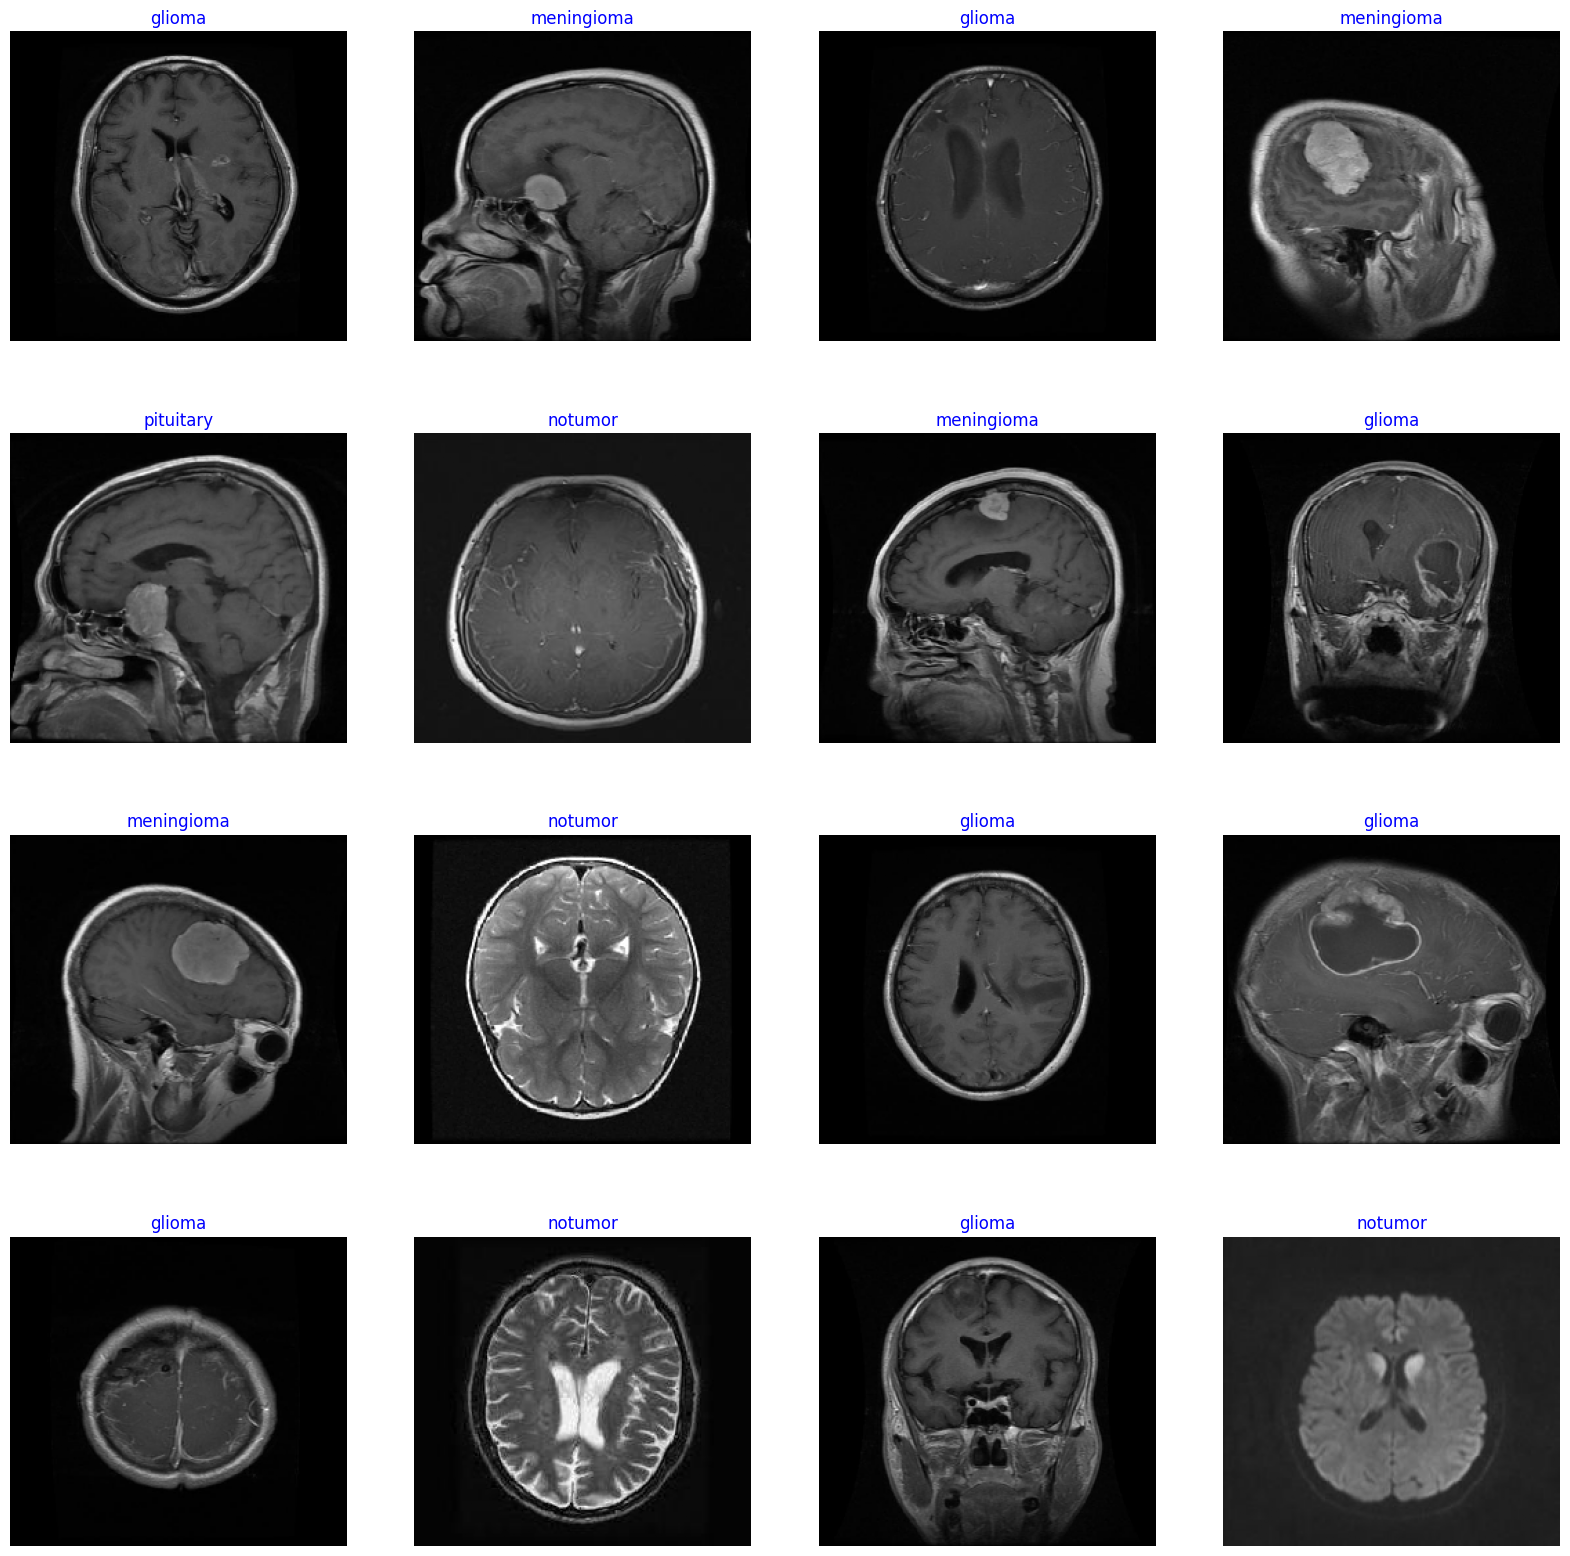

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

Model Structure

In [ ]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
input_shape = img_shape,pooling= 'max')

# Build the model using the Functional API instead of Sequential
input_tensor = tf.keras.Input(shape=img_shape)
x = base_model(input_tensor)
x = BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001)(x)  # Apply BatchNormalization after base_model
x = Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu')(x)
x = Dropout(rate= 0.4 , seed = 75)(x)
output_tensor = Dense(num_class , activation = 'softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)


model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

Iterate

In [ ]:
Epochs = 12

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 2173s 7s/step - accuracy: 0.5641 - loss: 10.9692 - val_accuracy: 0.3725 - val_loss: 5.8478
Epoch 2/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - accuracy: 0.5374 - loss: 5.3337 - val_accuracy: 0.5252 - val_loss: 4.0480
Epoch 3/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.6076 - loss: 3.7126 - val_accuracy: 0.5939 - val_loss: 2.8804
Epoch 4/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - accuracy: 0.6207 - loss: 2.6950 - val_accuracy: 0.6901 - val_loss: 2.1850
Epoch 5/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.7441 - loss: 1.9998 - val_accuracy: 0.6824 - val_loss: 1.7320
Epoch 6/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.7619 - loss: 1.5729 - val_accuracy: 0.7008 - val_loss: 1.3968
Epoch 7/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - accuracy: 0.7921 - loss: 1.3054 - val_accuracy: 0.7328 - val_loss: 1.1907
Epoch 8/12
298/298 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.8195 - loss: 1

model perfomance

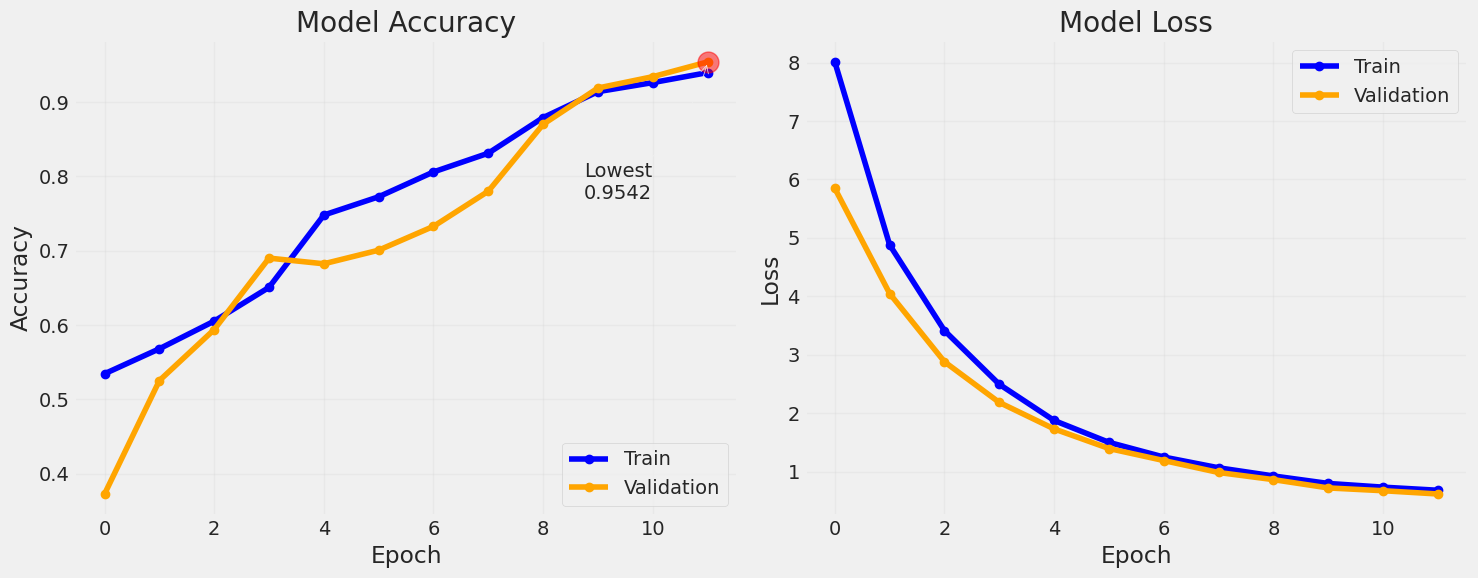

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9834 - loss: 0.5391
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9597 - loss: 0.6091
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.9350 - loss: 0.6626
Train Loss:  0.5573956966400146
Train Accuracy:  0.984375
--------------------
Validation Loss:  0.6214343905448914
Validation Accuracy:  0.953125
--------------------
Test Loss:  0.6547226905822754
Test Accuracy:  0.9375


Model Prediction

Confusion Matrix and Classification Report

In [ ]:
preds = model.predict(test_gen) # Use predict instead of predict_generator

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step


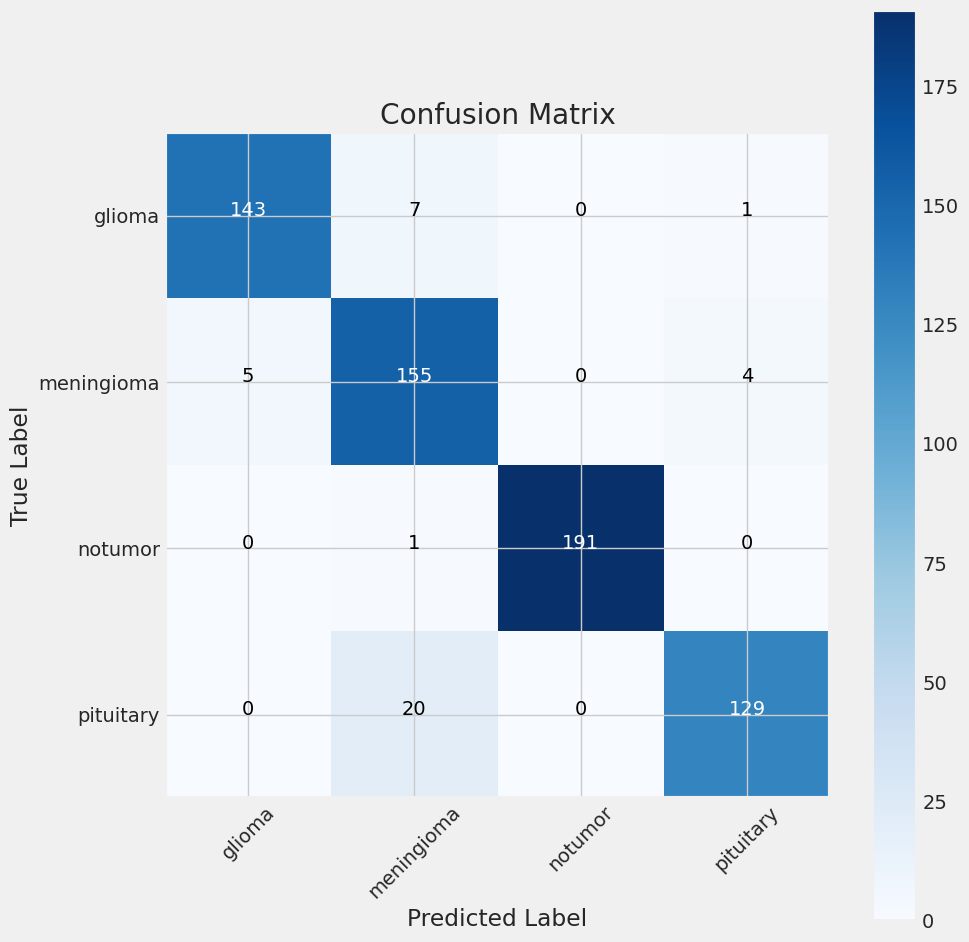

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       151
  meningioma       0.85      0.95      0.89       164
     notumor       1.00      0.99      1.00       192
   pituitary       0.96      0.87      0.91       149

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.95      0.94      0.94       656

